# Importing Libraries

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim

import torchtext
from torchtext.legacy.data import Field, BucketIterator, Iterator
from torchtext.legacy import data

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

import spacy
import numpy as np
import pandas as pd

import random
import math
import time
import pickle

In [2]:
torchtext.__version__

'0.9.0'

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

# Reading the text file

In [4]:
f = open("data\datav2.txt", "r", encoding = 'UTF-8')
file_lines = f.readlines()

In [5]:
file_lines[:20]

['# Write a Python program to calculate the square root of a number without using the math module\n',
 'num = 16\n',
 'sqrt = num ** 0.5\n',
 'print(f"The square root of {num} is {sqrt}")\n',
 '\n',
 '\n',
 '# Write a Python function to count the number of vowels in a string\n',
 'def count_vowels(s):\n',
 "    vowels = 'aeiouAEIOU'\n",
 '    count = 0\n',
 '    for char in s:\n',
 '        if char in vowels:\n',
 '            count += 1\n',
 '    return count\n',
 '\n',
 '\n',
 '# Write a Python program to print the Fibonacci series up to n terms\n',
 'n = 10\n',
 'a, b = 0, 1\n',
 'for _ in range(n):\n']


Our dataset is formulated in a manner where every question starts with '#'. Lines between two consecutive '#' forms the solution to the question.

In [6]:
dps = []
dp = None
for line in file_lines:
  if line[0] == "#":
    if dp:
      dp['solution'] = ''.join(dp['solution'])
      dps.append(dp)
    dp = {"question": None, "solution": []}
    dp['question'] = line[1:]
  else:
    dp["solution"].append(line)

Lets take a look at the first 50 entries of the data we have parsed.

In [7]:
i=0
for dp in dps:
  print("\n Question no: ", i+1)
  i+=1
  print(dp['question'][1:])
  print(dp['solution'])
  if i>49:
    break


 Question no:  1
Write a Python program to calculate the square root of a number without using the math module

num = 16
sqrt = num ** 0.5
print(f"The square root of {num} is {sqrt}")




 Question no:  2
Write a Python function to count the number of vowels in a string

def count_vowels(s):
    vowels = 'aeiouAEIOU'
    count = 0
    for char in s:
        if char in vowels:
            count += 1
    return count




 Question no:  3
Write a Python program to print the Fibonacci series up to n terms

n = 10
a, b = 0, 1
for _ in range(n):
    print(a, end=" ")
    a, b = b, a + b




 Question no:  4
Write a Python function to check if a number is an Armstrong number

def is_armstrong(num):
    sum_ = sum(int(digit) ** len(str(num)) for digit in str(num))
    return sum_ == num




 Question no:  5
Write a Python program to reverse a string

string = "Hello World"
reversed_string = string[::-1]
print(f"Reversed string: {reversed_string}")




 Question no:  6
Write a Python function 

In [8]:
print("Dataset size:", len(dps))

Dataset size: 5228


# Using a custom tokenizer to tokenize python code
Python is a programming language with its own unique syntax. Regular tokenizers like spacy are meant to tokenize english scentences and are not optimized towards Python's syntax. Here, we write our own custom tokenizer that makes use of Python's default tokenize library. When we make use of this library we only extract the token type and the token string.

In [9]:
from tokenize import tokenize, untokenize
import io
def tokenize_python_code(python_code_str):
    python_tokens = list(tokenize(io.BytesIO(python_code_str.encode('utf-8')).readline))
    tokenized_output = []
    for i in range(0, len(python_tokens)):
        tokenized_output.append((python_tokens[i].type, python_tokens[i].string))
    return tokenized_output

In [10]:
tokenized_sample = tokenize_python_code(dps[1]['solution'])
print(tokenized_sample)

[(62, 'utf-8'), (1, 'def'), (1, 'count_vowels'), (54, '('), (1, 's'), (54, ')'), (54, ':'), (4, '\n'), (5, '    '), (1, 'vowels'), (54, '='), (3, "'aeiouAEIOU'"), (4, '\n'), (1, 'count'), (54, '='), (2, '0'), (4, '\n'), (1, 'for'), (1, 'char'), (1, 'in'), (1, 's'), (54, ':'), (4, '\n'), (5, '        '), (1, 'if'), (1, 'char'), (1, 'in'), (1, 'vowels'), (54, ':'), (4, '\n'), (5, '            '), (1, 'count'), (54, '+='), (2, '1'), (4, '\n'), (6, ''), (6, ''), (1, 'return'), (1, 'count'), (4, '\n'), (61, '\n'), (61, '\n'), (6, ''), (0, '')]


In [11]:
print(untokenize(tokenized_sample).decode('utf-8'))

def count_vowels (s ):
    vowels ='aeiouAEIOU'
    count =0 
    for char in s :
        if char in vowels :
            count +=1 
    return count 





Since we have mere 5000 data points, we make use of data augmentations to increase the size of our dataset. While tokenizing the python code, we mask the names of certain variables randomly(with 'var_1, 'var_2' etc) to ensure that the model that we train does not merly fixate on the way the variables are named and actually tries to understand the inhrent logic and syntax of the python code.

But, while randomly picking varibles to mask we avoid keyword literals(keyword.kwlist), control structures(as can be seen in below skip_list) and object properties. We add all such literals that need to be skipped into the skip_list

skip_list = ['range', 'enumerate', 'print', 'ord', 'int', 'float', 'char', 'list', 'dict', 'tuple', 'set', 'len', 'sum', 'min', 'max']

In [12]:
import keyword

print(keyword.kwlist)

['False', 'None', 'True', 'and', 'as', 'assert', 'async', 'await', 'break', 'class', 'continue', 'def', 'del', 'elif', 'else', 'except', 'finally', 'for', 'from', 'global', 'if', 'import', 'in', 'is', 'lambda', 'nonlocal', 'not', 'or', 'pass', 'raise', 'return', 'try', 'while', 'with', 'yield']


In [13]:
def augment_tokenize_python_code(python_code_str, mask_factor=0.3):


    var_dict = {} # Dictionary that stores masked variables

    # certain reserved words that should not be treated as normal variables and
    # hence need to be skipped from our variable mask augmentations
    skip_list = ['range', 'enumerate', 'print', 'ord', 'int', 'float', 'zip'
                 'char', 'list', 'dict', 'tuple', 'set', 'len', 'sum', 'min', 'max']
    skip_list.extend(keyword.kwlist)

    var_counter = 1
    python_tokens = list(tokenize(io.BytesIO(python_code_str.encode('utf-8')).readline))
    tokenized_output = []

    for i in range(0, len(python_tokens)):
      if python_tokens[i].type == 1 and python_tokens[i].string not in skip_list:
        
        if i>0 and python_tokens[i-1].string in ['def', '.', 'import', 'raise', 'except', 'class']: # avoid masking modules, functions and error literals
          skip_list.append(python_tokens[i].string)
          tokenized_output.append((python_tokens[i].type, python_tokens[i].string))
        elif python_tokens[i].string in var_dict:  # if variable is already masked
          tokenized_output.append((python_tokens[i].type, var_dict[python_tokens[i].string]))
        elif random.uniform(0, 1) > 1-mask_factor: # randomly mask variables
          var_dict[python_tokens[i].string] = 'var_' + str(var_counter)
          var_counter+=1
          tokenized_output.append((python_tokens[i].type, var_dict[python_tokens[i].string]))
        else:
          skip_list.append(python_tokens[i].string)
          tokenized_output.append((python_tokens[i].type, python_tokens[i].string))
      
      else:
        tokenized_output.append((python_tokens[i].type, python_tokens[i].string))
    
    return tokenized_output

In [14]:
tokenized_sample = augment_tokenize_python_code(dps[1]['solution'])
print(tokenized_sample)

[(62, 'utf-8'), (1, 'def'), (1, 'count_vowels'), (54, '('), (1, 's'), (54, ')'), (54, ':'), (4, '\n'), (5, '    '), (1, 'vowels'), (54, '='), (3, "'aeiouAEIOU'"), (4, '\n'), (1, 'count'), (54, '='), (2, '0'), (4, '\n'), (1, 'for'), (1, 'char'), (1, 'in'), (1, 's'), (54, ':'), (4, '\n'), (5, '        '), (1, 'if'), (1, 'char'), (1, 'in'), (1, 'vowels'), (54, ':'), (4, '\n'), (5, '            '), (1, 'count'), (54, '+='), (2, '1'), (4, '\n'), (6, ''), (6, ''), (1, 'return'), (1, 'count'), (4, '\n'), (61, '\n'), (61, '\n'), (6, ''), (0, '')]


In [15]:
print(untokenize(tokenized_sample).decode('utf-8'))

def count_vowels (s ):
    vowels ='aeiouAEIOU'
    count =0 
    for char in s :
        if char in vowels :
            count +=1 
    return count 





As one can see our augmented tokenizer picked num2 randomly and masked(replaced) it with by var_1


# Building Train and Validation Datase

In [16]:
python_problems_df = pd.DataFrame(dps)

In [17]:
python_problems_df.head()

,question,solution
0,Write a Python program to calculate the squar...,"num = 16\nsqrt = num ** 0.5\nprint(f""The squar..."
1,Write a Python function to count the number o...,def count_vowels(s):\n vowels = 'aeiouAEIOU...
2,Write a Python program to print the Fibonacci...,"n = 10\na, b = 0, 1\nfor _ in range(n):\n p..."
3,Write a Python function to check if a number ...,def is_armstrong(num):\n sum_ = sum(int(dig...
4,Write a Python program to reverse a string\n,"string = ""Hello World""\nreversed_string = stri..."


In [18]:
python_problems_df.shape

(5228, 2)

In [19]:
np.random.seed(0)
msk = np.random.rand(len(python_problems_df)) < 0.85 # Splitting data into 85% train and 15% validation

train_df = python_problems_df[msk]
val_df = python_problems_df[~msk]

In [20]:
train_df.shape

(4452, 2)

In [21]:
val_df.shape

(776, 2)

# 
Creating vocabulary using torchtext
In this section we will use torchtext Fields to construct the vocabulary for our sequence-to-sequence learning problem.

In [22]:
SEED = 1234

random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

In [23]:
Input = data.Field(tokenize = 'spacy',
            init_token='', 
            eos_token='', 
            lower=True)

Output = data.Field(tokenize = augment_tokenize_python_code,
                    init_token='', 
                    eos_token='', 
                    lower=False)

C:\Users\shrey\anaconda3\envs\Testing\lib\site-packages\torchtext\data\utils.py:123: UserWarning: Spacy model "en" could not be loaded, trying "en_core_web_sm" instead
  warnings.warn(f'Spacy model "{language}" could not be loaded, trying "{OLD_MODEL_SHORTCUTS[language]}" instead')


In [24]:
fields = [('Input', Input),('Output', Output)]

Since our data augmentations have the potential to increase the vocabulary beyond what it initially is, we must ensure that we capture as many variations as possible in the vocabulary that we develop. In the the below code we apply our data augmentations 100 times to ensure that we can capture a majority of augmentations into our vocabulary.

In [25]:
train_example = []
val_example = []

train_expansion_factor = 100
for j in range(train_expansion_factor):
  for i in range(train_df.shape[0]):
      try:
          ex = data.Example.fromlist([train_df.question[i], train_df.solution[i]], fields)
          train_example.append(ex)
      except:
          pass

for i in range(val_df.shape[0]):
    try:
        ex = data.Example.fromlist([val_df.question[i], val_df.solution[i]], fields)
        val_example.append(ex)
    except:
        pass

In [26]:
train_data = data.Dataset(train_example, fields)
valid_data =  data.Dataset(val_example, fields)

In [27]:
Input.build_vocab(train_data, min_freq = 0)
Output.build_vocab(train_data, min_freq = 0)

In [28]:
Output.vocab

In [29]:
def save_vocab(vocab, path):
    output = open(path, 'wb')
    pickle.dump(vocab, output)
    output.close()

In [30]:
save_vocab(Input.vocab, r"vocabulary\Input_vocab.pkl")
save_vocab(Output.vocab, r"vocabulary\Output_vocab.pkl")

# Transformer Architecture

<img src="images/tranformer.png" style="display: block; margin: 0 auto;">

Our transformer can be understood in terms of its three components:
1. An Encoder that encodes an input sequence into state representation vectors.
2. An Attention mechanism that enables our Transformer model to focus on the right aspects of the sequential input stream. This is used repeatedly within both the encoder and the decoder to help them contextualize the input data.
3. A Decoder that decodes the state representation vector to generate the target output sequence

# Encoder

<img src="images/encoder-output.png" style="display: block; margin: 0 auto;">

Our Encoder accepts a batch of source sequences and sequence masks as input. The source mask contains 1 in locations where the input sequence has valid values and 0 where the input sequence has <pad> values. This ensures that the attention mechanism within the encoder does not pay attention to <pad> values.

We convert our source sequence tokens into embeddings(‘tok_embedding’) of ‘hid_dim’ length. Since were are not using any recurrent networks we need to tag each token with its positional indices in order to preserve sequential information. We create an indices tensor(i.e. ‘pos’) and convert this into an embedding(‘pos_embedding’) of length ‘hid_dim’. This is combined with the source sequence embeddings to create our initial Encoder Layer input tensor src. This src tensor is passed through a series of Encoder Layers.

In [31]:
class Encoder(nn.Module):
    def __init__(self, 
                 input_dim, 
                 hid_dim, 
                 n_layers, 
                 n_heads, 
                 pf_dim,
                 dropout, 
                 device,
                 max_length = 1000):
        super().__init__()

        self.device = device
        
        self.tok_embedding = nn.Embedding(input_dim, hid_dim)
        self.pos_embedding = nn.Embedding(max_length, hid_dim)
        
        self.layers = nn.ModuleList([EncoderLayer(hid_dim, 
                                                  n_heads, 
                                                  pf_dim,
                                                  dropout, 
                                                  device) 
                                     for _ in range(n_layers)])
        
        self.dropout = nn.Dropout(dropout)
        
        self.scale = torch.sqrt(torch.FloatTensor([hid_dim])).to(device)
        
    def forward(self, src, src_mask):
        
        batch_size = src.shape[0]
        src_len = src.shape[1]

        pos = torch.arange(0, src_len).unsqueeze(0).repeat(batch_size, 1).to(self.device)
        
        src = self.dropout((self.tok_embedding(src) * self.scale) + self.pos_embedding(pos))
        
        for layer in self.layers:
            src = layer(src, src_mask)
            
        return src

An EncoderLayer is the basic building block of our Transformer’s Encoder component. Our src tensor along with its ‘src_mask’ are sent into a multi-head self-attention operation to help our model focus on the necessary aspects of the src tensor. The output from the attention operation is combined with the src tensor(via skip connection) and normalized to avoid vanishing/exploding gradients(during training). This combined output is sent into a PositionwiseFeedForwardLayer.

In [32]:
class EncoderLayer(nn.Module):
    def __init__(self, 
                 hid_dim, 
                 n_heads, 
                 pf_dim,  
                 dropout, 
                 device):
        super().__init__()
        
        self.self_attn_layer_norm = nn.LayerNorm(hid_dim)
        self.ff_layer_norm = nn.LayerNorm(hid_dim)
        self.self_attention = MultiHeadAttentionLayer(hid_dim, n_heads, dropout, device)
        self.positionwise_feedforward = PositionwiseFeedforwardLayer(hid_dim, 
                                                                     pf_dim, 
                                                                     dropout)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, src, src_mask):
        
        #self attention
        _src, _ = self.self_attention(src, src, src, src_mask)
        
        #dropout, residual connection and layer norm
        src = self.self_attn_layer_norm(src + self.dropout(_src))
        
        #positionwise feedforward
        _src = self.positionwise_feedforward(src)
        
        #dropout, residual and layer norm
        src = self.ff_layer_norm(src + self.dropout(_src))
        
        return src


A PositionwiseFeedForwardLayer takes the combined input and processes it further using two fully connected layers and a Relu activation function between them. This in combination with the src embedding is the final output of an EncoderLayer. This process repeats for each EncoderLayer block.

In [33]:
class PositionwiseFeedforwardLayer(nn.Module):
    def __init__(self, hid_dim, pf_dim, dropout):
        super().__init__()
        
        self.fc_1 = nn.Linear(hid_dim, pf_dim)
        self.fc_2 = nn.Linear(pf_dim, hid_dim)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, x):
        x = self.dropout(torch.relu(self.fc_1(x)))
        x = self.fc_2(x)
        
        return x

# Attention

<img src="images/self-attention_visualization.png" style="display: block; margin: 0 auto;">

Attention is a mechanism that allows a model to focus on the necessary parts of the input sequence as per the demands of the task at hand.

Researchers at google like to look at everything as an information retrieval problem. Therefore the [“Attention is all you need”](https://arxiv.org/abs/1706.03762) paper tries to look at attention in terms of “Query”, “Keys” and “Values”. A search engine accepts a “Query” and tries to match it up with Indices(i.e. Keys) in order to get appropriate values as results for the query. Similarly one can think of attention as a mechanism in which the query vector and key vector work towards getting the right attention weights(i.e. values).

When multiple channels(or heads) of attention are applied in parallel to a single source, it is known as multi-head attention. This increases the learning capacity of the model and therefore leads to better results.

In [34]:
class MultiHeadAttentionLayer(nn.Module):
    def __init__(self, hid_dim, n_heads, dropout, device):
        super().__init__()
        
        assert hid_dim % n_heads == 0
        
        self.hid_dim = hid_dim
        self.n_heads = n_heads
        self.head_dim = hid_dim // n_heads
        
        self.fc_q = nn.Linear(hid_dim, hid_dim)
        self.fc_k = nn.Linear(hid_dim, hid_dim)
        self.fc_v = nn.Linear(hid_dim, hid_dim)
        
        self.fc_o = nn.Linear(hid_dim, hid_dim)
        
        self.dropout = nn.Dropout(dropout)
        
        self.scale = torch.sqrt(torch.FloatTensor([self.head_dim])).to(device)
        
    def forward(self, query, key, value, mask = None):
        
        batch_size = query.shape[0]
                
        Q = self.fc_q(query)
        K = self.fc_k(key)
        V = self.fc_v(value)
                
        Q = Q.view(batch_size, -1, self.n_heads, self.head_dim).permute(0, 2, 1, 3)
        K = K.view(batch_size, -1, self.n_heads, self.head_dim).permute(0, 2, 1, 3)
        V = V.view(batch_size, -1, self.n_heads, self.head_dim).permute(0, 2, 1, 3)
                
        energy = torch.matmul(Q, K.permute(0, 1, 3, 2)) / self.scale
        
        if mask is not None:
            energy = energy.masked_fill(mask == 0, -1e10)
        
        attention = torch.softmax(energy, dim = -1)
                
        x = torch.matmul(self.dropout(attention), V)
        
        x = x.permute(0, 2, 1, 3).contiguous()
        
        x = x.view(batch_size, -1, self.hid_dim)
        
        x = self.fc_o(x)
        
        return x, attention

# Decoder

<img src="images/decoder-source-target-2.png" style="display: block; margin: 0 auto;">

The architecture of a Decoder is very similar to that of the encoder with the significant differences resulting from the presence of input from two sources, the target sequence and the state representation vector from the encoder. Much like how we had an EncoderLayer block for Encoder, we will be having a DecoderLayer that accepts as input the combination of the embedding from the target token sequence(tok_embedding) and embedding of positional indices for these tokens. And as mentioned earlier, the encoder’s output also acts as one of the inputs to the DecoderLayer.

In [35]:
class Decoder(nn.Module):
    def __init__(self, 
                 output_dim, 
                 hid_dim, 
                 n_layers, 
                 n_heads, 
                 pf_dim, 
                 dropout, 
                 device,
                 max_length = 10000):
        super().__init__()
        
        self.device = device
        
        self.tok_embedding = nn.Embedding(output_dim, hid_dim)
        
        self.pos_embedding = nn.Embedding(max_length, hid_dim)
        
        self.layers = nn.ModuleList([DecoderLayer(hid_dim, 
                                                  n_heads, 
                                                  pf_dim, 
                                                  dropout, 
                                                  device)
                                     for _ in range(n_layers)])
        
        self.fc_out = nn.Linear(hid_dim, output_dim)
        
        self.dropout = nn.Dropout(dropout)
        
        self.scale = torch.sqrt(torch.FloatTensor([hid_dim])).to(device)
        
    def forward(self, trg, enc_src, trg_mask, src_mask):
                
        batch_size = trg.shape[0]
        
        trg_len = trg.shape[1]
        
        pos = torch.arange(0, trg_len).unsqueeze(0).repeat(batch_size, 1).to(self.device)

        trg = self.dropout((self.tok_embedding(trg) * self.scale) + self.pos_embedding(pos))
        
        for layer in self.layers:
            trg, attention = layer(trg, enc_src, trg_mask, src_mask)
        
        output = self.fc_out(trg)
            
        return output, attention

The DecoderLayer forms the building block of our Transformer’s decoder. Each DecoderLayer involves two attention operations:
1. Self-attention on trg embedding.
2. Multi-head attention operation that uses the trg as query vector and the encoder outputs act as the key and value vectors.

The presence of an extra Multi-head attention operation differentiates the DecoderLayer from an EncoderLayer.

The attention outputs from self-attention are normalized and combined with the trg embedding using a residual connection. This is then sent into the multi-head attention operation along with the encoder outputs. The attention layer outputs are then combined with the trg input again and normalized before sending it into the position-wise feedforward layer to generate the final outputs of the DecoderLayer.

The purpose of all normalization operations is to prevent vanishing/exploding gradients during training.

In [36]:
class DecoderLayer(nn.Module):
    def __init__(self, 
                 hid_dim, 
                 n_heads, 
                 pf_dim, 
                 dropout, 
                 device):
        super().__init__()
        
        self.self_attn_layer_norm = nn.LayerNorm(hid_dim)
        self.enc_attn_layer_norm = nn.LayerNorm(hid_dim)
        self.ff_layer_norm = nn.LayerNorm(hid_dim)
        self.self_attention = MultiHeadAttentionLayer(hid_dim, n_heads, dropout, device)
        self.encoder_attention = MultiHeadAttentionLayer(hid_dim, n_heads, dropout, device)
        self.positionwise_feedforward = PositionwiseFeedforwardLayer(hid_dim, 
                                                                     pf_dim, 
                                                                     dropout)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, trg, enc_src, trg_mask, src_mask):
        
        #self attention
        _trg, _ = self.self_attention(trg, trg, trg, trg_mask)
        
        #dropout, residual connection and layer norm
        trg = self.self_attn_layer_norm(trg + self.dropout(_trg))
            
        #encoder attention
        _trg, attention = self.encoder_attention(trg, enc_src, enc_src, src_mask)
        # query, key, value
        
        #dropout, residual connection and layer norm
        trg = self.enc_attn_layer_norm(trg + self.dropout(_trg))
        
        #positionwise feedforward
        _trg = self.positionwise_feedforward(trg)
        
        #dropout, residual and layer norm
        trg = self.ff_layer_norm(trg + self.dropout(_trg))
        
        return trg, attention
     

The main class that implements a transformer for seq2seq problems is given below.

In [37]:
class Seq2Seq(nn.Module):
    def __init__(self, 
                 encoder, 
                 decoder, 
                 src_pad_idx, 
                 trg_pad_idx, 
                 device):
        super().__init__()
        
        self.encoder = encoder
        self.decoder = decoder
        self.src_pad_idx = src_pad_idx
        self.trg_pad_idx = trg_pad_idx
        self.device = device
        
    def make_src_mask(self, src):
        
        src_mask = (src != self.src_pad_idx).unsqueeze(1).unsqueeze(2)

        return src_mask
    
    def make_trg_mask(self, trg):
        
        trg_pad_mask = (trg != self.trg_pad_idx).unsqueeze(1).unsqueeze(2)
        
        trg_len = trg.shape[1]
        
        trg_sub_mask = torch.tril(torch.ones((trg_len, trg_len), device = self.device)).bool()
            
        trg_mask = trg_pad_mask & trg_sub_mask

        return trg_mask

    def forward(self, src, trg):
        
        src_mask = self.make_src_mask(src)
        trg_mask = self.make_trg_mask(trg)

        enc_src = self.encoder(src, src_mask)
        
        output, attention = self.decoder(trg, enc_src, trg_mask, src_mask)

        return output, attention

# Training

In [38]:
INPUT_DIM = len(Input.vocab)
OUTPUT_DIM = len(Output.vocab)
HID_DIM = 256
ENC_LAYERS = 3
DEC_LAYERS = 3
ENC_HEADS = 16
DEC_HEADS = 16
ENC_PF_DIM = 512
DEC_PF_DIM = 512
ENC_DROPOUT = 0.1
DEC_DROPOUT = 0.1

enc = Encoder(INPUT_DIM, 
              HID_DIM, 
              ENC_LAYERS, 
              ENC_HEADS, 
              ENC_PF_DIM, 
              ENC_DROPOUT, 
              device)

dec = Decoder(OUTPUT_DIM, 
              HID_DIM, 
              DEC_LAYERS, 
              DEC_HEADS, 
              DEC_PF_DIM, 
              DEC_DROPOUT, 
              device)

In [39]:
len(Output.vocab.__dict__['freqs'])

5946

In [40]:
SRC_PAD_IDX = Input.vocab.stoi[Input.pad_token]
TRG_PAD_IDX = Output.vocab.stoi[Output.pad_token]

model = Seq2Seq(enc, dec, SRC_PAD_IDX, TRG_PAD_IDX, device).to(device)

In [41]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 10,384,957 trainable parameters


In [42]:
def initialize_weights(m):
    if hasattr(m, 'weight') and m.weight.dim() > 1:
        nn.init.xavier_uniform_(m.weight.data)

In [43]:
model.apply(initialize_weights);

In [44]:
LEARNING_RATE = 0.0005

optimizer = torch.optim.AdamW(model.parameters(), lr = LEARNING_RATE)

# Loss Function

We have used augmentations in our dataset to mask variable literals. This means that our model can predict a variety of values for a particular variable and all of them are correct as long as the predictions are consistent through the code. This would mean that our training labels are not very certain and hence it would make more sense to treat them to be correct with probability ```1- smooth_eps``` and incorrect otherwise. This is what label smoothening enables us to do. The following is the implementation of CrossEntropyLoss with label smoothening.

In [45]:
import torch
import math
import torch.nn as nn
import torch.nn.functional as F

class CrossEntropyLoss(nn.CrossEntropyLoss):
    """CrossEntropyLoss - with ability to recieve distrbution as targets, and optional label smoothing"""

    def __init__(self, weight=None, ignore_index=-100, reduction='mean', smooth_eps=None, smooth_dist=None, from_logits=True):
        super(CrossEntropyLoss, self).__init__(weight=weight,
                                               ignore_index=ignore_index, reduction=reduction)
        self.smooth_eps = smooth_eps
        self.smooth_dist = smooth_dist
        self.from_logits = from_logits

    def forward(self, input, target, smooth_dist=None):
        if smooth_dist is None:
            smooth_dist = self.smooth_dist
        return cross_entropy(input, target, weight=self.weight, ignore_index=self.ignore_index,
                             reduction=self.reduction, smooth_eps=self.smooth_eps,
                             smooth_dist=smooth_dist, from_logits=self.from_logits)


def cross_entropy(inputs, target, weight=None, ignore_index=-100, reduction='mean',
                  smooth_eps=None, smooth_dist=None, from_logits=True):
    """cross entropy loss, with support for target distributions and label smoothing https://arxiv.org/abs/1512.00567"""
    smooth_eps = smooth_eps or 0

    # ordinary log-liklihood - use cross_entropy from nn
    if _is_long(target) and smooth_eps == 0:
        if from_logits:
            return F.cross_entropy(inputs, target, weight, ignore_index=ignore_index, reduction=reduction)
        else:
            return F.nll_loss(inputs, target, weight, ignore_index=ignore_index, reduction=reduction)

    if from_logits:
        # log-softmax of inputs
        lsm = F.log_softmax(inputs, dim=-1)
    else:
        lsm = inputs

    masked_indices = None
    num_classes = inputs.size(-1)

    if _is_long(target) and ignore_index >= 0:
        masked_indices = target.eq(ignore_index)

    if smooth_eps > 0 and smooth_dist is not None:
        if _is_long(target):
            target = onehot(target, num_classes).type_as(inputs)
        if smooth_dist.dim() < target.dim():
            smooth_dist = smooth_dist.unsqueeze(0)
        target.lerp_(smooth_dist, smooth_eps)

    if weight is not None:
        lsm = lsm * weight.unsqueeze(0)

    if _is_long(target):
        eps_sum = smooth_eps / num_classes
        eps_nll = 1. - eps_sum - smooth_eps
        likelihood = lsm.gather(dim=-1, index=target.unsqueeze(-1)).squeeze(-1)
        loss = -(eps_nll * likelihood + eps_sum * lsm.sum(-1))
    else:
        loss = -(target * lsm).sum(-1)

    if masked_indices is not None:
        loss.masked_fill_(masked_indices, 0)

    if reduction == 'sum':
        loss = loss.sum()
    elif reduction == 'mean':
        if masked_indices is None:
            loss = loss.mean()
        else:
            loss = loss.sum() / float(loss.size(0) - masked_indices.sum())

    return loss


def onehot(indexes, N=None, ignore_index=None):
    """
    Creates a one-representation of indexes with N possible entries
    if N is not specified, it will suit the maximum index appearing.
    indexes is a long-tensor of indexes
    ignore_index will be zero in onehot representation
    """
    if N is None:
        N = indexes.max() + 1
    sz = list(indexes.size())
    output = indexes.new().byte().resize_(*sz, N).zero_()
    output.scatter_(-1, indexes.unsqueeze(-1), 1)
    if ignore_index is not None and ignore_index >= 0:
        output.masked_fill_(indexes.eq(ignore_index).unsqueeze(-1), 0)
    return output

def _is_long(x):
    if hasattr(x, 'data'):
        x = x.data
    return isinstance(x, torch.LongTensor) or isinstance(x, torch.cuda.LongTensor)

In [46]:
def maskNLLLoss(inp, target, mask):
    nTotal = mask.sum()
    crossEntropy = CrossEntropyLoss(ignore_index = TRG_PAD_IDX, smooth_eps=0.20)
    loss = crossEntropy(inp, target)
    loss = loss.to(device)
    return loss, nTotal.item()

In [47]:
criterion = maskNLLLoss

# Training
In order to re-apply our augmentations differently in every epoch we re-create our dataset and dataloaders at the start of each epoch. This regularizes our training process and helps us come up with better models.

In [48]:
from tqdm import tqdm

def make_trg_mask(trg):

        trg_pad_mask = (trg != TRG_PAD_IDX).unsqueeze(1).unsqueeze(2)

        trg_len = trg.shape[1]
        
        trg_sub_mask = torch.tril(torch.ones((trg_len, trg_len), device = device)).bool()
   
        trg_mask = trg_pad_mask & trg_sub_mask

        return trg_mask

def train(model, iterator, optimizer, criterion, clip):
    
    model.train()
    
    n_totals = 0
    print_losses = []
    for i, batch in tqdm(enumerate(iterator), total=len(iterator)):
        # print(batch)
        loss = 0
        src = batch.Input.permute(1, 0)
        trg = batch.Output.permute(1, 0)
        trg_mask = make_trg_mask(trg)
        optimizer.zero_grad()
        
        output, _ = model(src, trg[:,:-1])
        
        output_dim = output.shape[-1]
            
        output = output.contiguous().view(-1, output_dim)
        trg = trg[:,1:].contiguous().view(-1)
    
        mask_loss, nTotal = criterion(output, trg, trg_mask)
        
        mask_loss.backward()
        
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        
        optimizer.step()
        
        print_losses.append(mask_loss.item() * nTotal)
        n_totals += nTotal

    return sum(print_losses) / n_totals

In [49]:
def evaluate(model, iterator, criterion):
    
    model.eval()
    
    n_totals = 0
    print_losses = []
    
    with torch.no_grad():
    
        for i, batch in tqdm(enumerate(iterator), total=len(iterator)):

            src = batch.Input.permute(1, 0)
            trg = batch.Output.permute(1, 0)
            trg_mask = make_trg_mask(trg)

            output, _ = model(src, trg[:,:-1])

            output_dim = output.shape[-1]
            
            output = output.contiguous().view(-1, output_dim)
            trg = trg[:,1:].contiguous().view(-1)

            mask_loss, nTotal = criterion(output, trg, trg_mask)

            print_losses.append(mask_loss.item() * nTotal)
            n_totals += nTotal

        
    return sum(print_losses) / n_totals

In [50]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [51]:
N_EPOCHS = 5
CLIP = 1

best_valid_loss = float('inf')

for epoch in range(N_EPOCHS):
    
    start_time = time.time()
    
    train_example = []
    val_example = []

    for i in range(train_df.shape[0]):
        try:
            ex = data.Example.fromlist([train_df.question[i], train_df.solution[i]], fields)
            train_example.append(ex)
        except:
            pass

    for i in range(val_df.shape[0]):
        try:
            ex = data.Example.fromlist([val_df.question[i], val_df.solution[i]], fields)
            val_example.append(ex)
        except:
            pass       

    train_data = data.Dataset(train_example, fields)
    valid_data =  data.Dataset(val_example, fields)

    BATCH_SIZE = 16
    train_iterator, valid_iterator = BucketIterator.splits((train_data, valid_data), batch_size = BATCH_SIZE, 
                                                                sort_key = lambda x: len(x.Input),
                                                                sort_within_batch=True, device = device)

    train_loss = train(model, train_iterator, optimizer, criterion, CLIP)
    valid_loss = evaluate(model, valid_iterator, criterion)
    
    end_time = time.time()
    
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save({'model_state_dict': model.state_dict(),'optimizer_state_dict': optimizer.state_dict(),'best_valid_loss': best_valid_loss,}
                   ,'model/model2.pt')
    
    print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f}')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. PPL: {math.exp(valid_loss):7.3f}')

100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 23.47it/s]


Epoch: 01 | Time: 1m 2s
	Train Loss: 5.045 | Train PPL: 155.320
	 Val. Loss: 4.326 |  Val. PPL:  75.619


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 23.25it/s]


Epoch: 02 | Time: 1m 0s
	Train Loss: 4.207 | Train PPL:  67.158
	 Val. Loss: 4.048 |  Val. PPL:  57.261


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 20.51it/s]


Epoch: 03 | Time: 1m 2s
	Train Loss: 3.989 | Train PPL:  53.981
	 Val. Loss: 3.930 |  Val. PPL:  50.928


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 21.83it/s]


Epoch: 04 | Time: 1m 2s
	Train Loss: 3.823 | Train PPL:  45.720
	 Val. Loss: 3.862 |  Val. PPL:  47.566


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 20.54it/s]


Epoch: 05 | Time: 1m 1s
	Train Loss: 3.703 | Train PPL:  40.557
	 Val. Loss: 3.746 |  Val. PPL:  42.350


# Retrain the Model from Saved Checkpoint

In [52]:
checkpoint = torch.load('model/model2.pt')
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
best_valid_loss = checkpoint['best_valid_loss']

# Set the model to training mode
model.train()

# Continue training
for epoch in range(2): # Set the number of epochs you want to retain the model on
    
    start_time = time.time()
    
    train_example = []
    val_example = []

    for i in range(train_df.shape[0]):
        try:
            ex = data.Example.fromlist([train_df.question[i], train_df.solution[i]], fields)
            train_example.append(ex)
        except:
            pass

    for i in range(val_df.shape[0]):
        try:
            ex = data.Example.fromlist([val_df.question[i], val_df.solution[i]], fields)
            val_example.append(ex)
        except:
            pass       

    train_data = data.Dataset(train_example, fields)
    valid_data =  data.Dataset(val_example, fields)

    BATCH_SIZE = 16
    train_iterator, valid_iterator = BucketIterator.splits((train_data, valid_data), batch_size = BATCH_SIZE, 
                                                                sort_key = lambda x: len(x.Input),
                                                                sort_within_batch=True, device = device)

    train_loss = train(model, train_iterator, optimizer, criterion, CLIP)
    valid_loss = evaluate(model, valid_iterator, criterion)
    
    end_time = time.time()
    
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save({'model_state_dict': model.state_dict(),'optimizer_state_dict': optimizer.state_dict(),'best_valid_loss': best_valid_loss,}
                   ,'model/model2.pt')
    
    
    print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f}')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. PPL: {math.exp(valid_loss):7.3f}')


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 22.23it/s]


Epoch: 01 | Time: 1m 1s
	Train Loss: 3.611 | Train PPL:  36.991
	 Val. Loss: 3.719 |  Val. PPL:  41.226


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 20.09it/s]


Epoch: 02 | Time: 1m 4s
	Train Loss: 3.521 | Train PPL:  33.830
	 Val. Loss: 3.635 |  Val. PPL:  37.907


In [53]:
SRC = Input
TRG = Output

### LOAD THE MODEL

In [63]:
checkpoint = torch.load('model/model1.pt')
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
best_valid_loss = checkpoint['best_valid_loss']

In [64]:
def translate_sentence(sentence, src_field, trg_field, model, device, max_len = 50000):
    
    model.eval()
        
    if isinstance(sentence, str):
        nlp = spacy.load('en')
        tokens = [token.text.lower() for token in nlp(sentence)]
    else:
        tokens = [token.lower() for token in sentence]

    tokens = [src_field.init_token] + tokens + [src_field.eos_token]
        
    src_indexes = [src_field.vocab.stoi[token] for token in tokens]

    src_tensor = torch.LongTensor(src_indexes).unsqueeze(0).to(device)
    
    src_mask = model.make_src_mask(src_tensor)
    
    with torch.no_grad():
        enc_src = model.encoder(src_tensor, src_mask)

    trg_indexes = [trg_field.vocab.stoi[trg_field.init_token]]

    for i in range(max_len):

        trg_tensor = torch.LongTensor(trg_indexes).unsqueeze(0).to(device)

        trg_mask = model.make_trg_mask(trg_tensor)
        
        with torch.no_grad():
            output, attention = model.decoder(trg_tensor, enc_src, trg_mask, src_mask)
        
        pred_token = output.argmax(2)[:,-1].item()
        
        trg_indexes.append(pred_token)

        if pred_token == trg_field.vocab.stoi[trg_field.eos_token]:
            break
    
    trg_tokens = [trg_field.vocab.itos[i] for i in trg_indexes]
    
    return trg_tokens[1:], attention

In [65]:
def display_attention(sentence, translation, attention, n_heads = 8, n_rows = 4, n_cols = 2):
    
    assert n_rows * n_cols == n_heads
    
    fig = plt.figure(figsize=(30,50))
    
    for i in range(n_heads):
        
        ax = fig.add_subplot(n_rows, n_cols, i+1)
        
        _attention = attention.squeeze(0)[i].cpu().detach().numpy()

        cax = ax.matshow(_attention, cmap='bone')

        ax.tick_params(labelsize=12)
        ax.set_xticklabels(['']+['<sos>']+[t.lower() for t in sentence]+['<eos>'], 
                           rotation=45)
        ax.set_yticklabels(['']+translation)

        ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
        ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()

In [66]:
src = "write a function that adds two numbers"
src=src.split(" ")
translation, attention = translate_sentence(src, SRC, TRG, model, device)

print(f'predicted trg sequence: ')
print(translation)
print("code: \n", untokenize(translation[:-1]).decode('utf-8'))

predicted trg sequence: 
[(62, 'utf-8'), (1, 'def'), (1, 'add'), (54, '('), (1, 'x'), (54, ','), (1, 'y'), (54, ')'), (54, ':'), (4, '\n'), (5, '    '), (1, 'return'), (1, 'x'), (54, '+'), (1, 'y'), (4, ''), (6, ''), (0, ''), '']
code: 
 def add (x ,y ):
    return x +y 


C:\Users\shrey\AppData\Local\Temp\ipykernel_16396\2379752938.py:16: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['']+['<sos>']+[t.lower() for t in sentence]+['<eos>'],
C:\Users\shrey\AppData\Local\Temp\ipykernel_16396\2379752938.py:18: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(['']+translation)


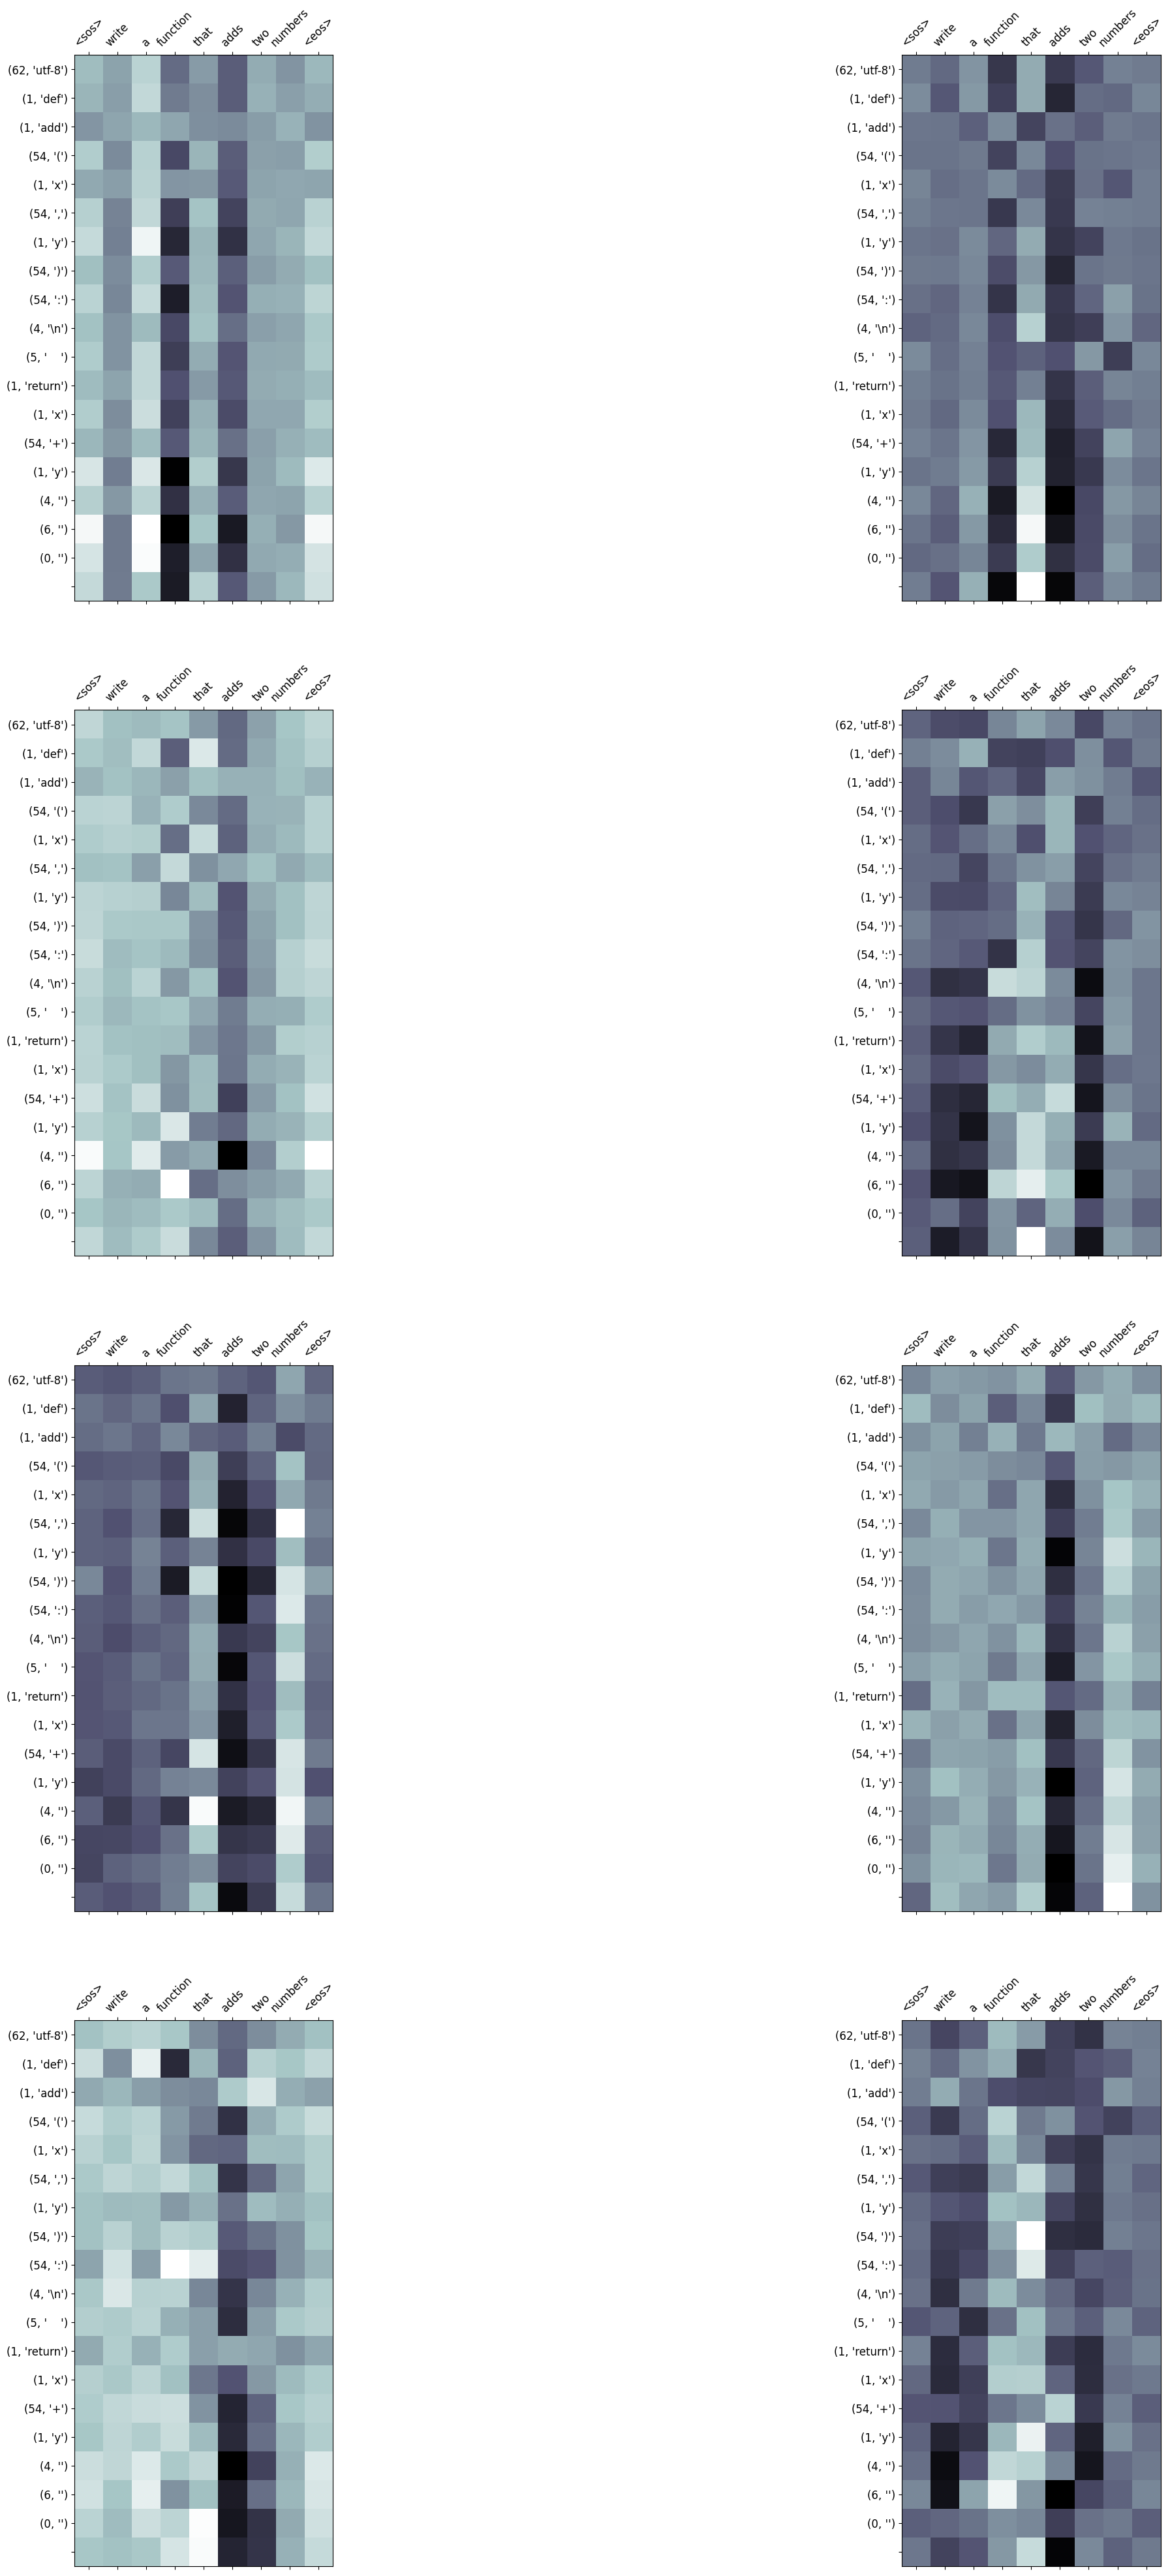

In [67]:
display_attention(src, translation, attention)

# Sample Outputs for Python Code Generation
Lets load our pretrained model to perform inference on a set of examples

Function that translates an English src string to python code.

In [68]:
def eng_to_python(src):
  src=src.split(" ")
  translation, attention = translate_sentence(src, SRC, TRG, model, device)

  print(f'predicted trg: \n')
  # print(translation)
  print(untokenize(translation[:-1]).decode('utf-8'))

# Examples

In [69]:
src = "program to sort a list of dictionaries by key"

eng_to_python(src)

predicted trg: 

var_1 ={"a":1 ,"b":2 ,"c":3 ,"d":4 }
for k ,v in var_1 .items ():
    print (k ,v )


In [70]:
src = "write a function to merge two lists"

eng_to_python(src)

predicted trg: 

def merge_lists (var_1 :list ,l2 :list ):
    return list (zip (var_1 ,l2 ))
